# Imports

In [1]:
from gliderad2cp import process_adcp
import xarray as xr
import numpy as np
import pandas as pd
import pooch

# 1 Calculate shear

This process is shown in much more detail in notebook **01_calculate_velocity_shear**

In [2]:
data_source = pooch.create(
    path=pooch.os_cache("gliderad2cp"),
    base_url="https://zenodo.org/record/8431329/files/",
    registry={
            "adcp_profiles_10_to_1170.nc": "sha256:a759047946176c704b0aa39701ef23c78cbaf41b6eac6253fa280388e3d63c90",
            "adcp_profiles_10_to_210.nc": "sha256:7d82db74164ba38adf97f43d5d447a867d155ccc1bbe1727d8fe0ffcedc4f0db",
            "adcp_profiles_160_to_210.nc": "sha256:323ff3cc6402b6c7034a57369ee637c1398af38c2d5f876c0456dbbf9928ab6f",
            "glider_profiles_10_to_1170.pqt": "sha256:9066ef8e8009a953ca572ae40b2070c6cf2307722c09c30ebb7a3a0ad9a6ae36",
            "glider_profiles_10_to_210.pqt": "sha256:fbea59a95470b69d1c6c2fe9f7db6cf6a4343a1cc7a471892fc654f09d195dd5",
            "glider_profiles_160_to_210.pqt": "sha256:ee83f2d0f3bac1c937da4115c5904b7429a3531406654747dd64845a3aeeb7b5",
            "processed_velocity_10_to_1170.nc": "sha256:76b8f1e14a1896a7c086b769f848d84f7e61fe6e5d455d59b95b9795c042e0ae",
            "processed_velocity_10_to_210.nc": "sha256:e70be7a7d035b86d6bb25959415a751abea4127c9599cb07c555e9e9da77c356",
            "processed_velocity_160_to_210.nc": "sha256:cb6f0ccd580db111ad6b54da9f8db831632f461740eb78b26141964b6abe97b6",
            },
)
profile_range = "10_to_210" # Medium dataset
#profile_range = "10_to_1170" # Full dataset - Slow to process!
#profile_range = "160_to_210" # Small dataset


glider_pqt_path = data_source.get_url(f"glider_profiles_{profile_range}.pqt")
data_source.fetch(f"adcp_profiles_{profile_range}.nc")
adcp_path = str(data_source.path / f"adcp_profiles_{profile_range}.nc")

options = {
    'debug_plots' : False,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    }


In [3]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)
ADCP = process_adcp.remapADCPdepth(ADCP, options)
ADCP = process_adcp.correct_heading(ADCP, data, options)
ADCP = process_adcp.soundspeed_correction(ADCP)
ADCP = process_adcp.remove_outliers(ADCP, options)
ADCP = process_adcp.correct_shear(ADCP, options)
ADCP = process_adcp.correct_backscatter(ADCP, data, options)
ADCP = process_adcp.regridADCPdata(ADCP, options)
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)

Loaded https://zenodo.org/record/8431329/files/glider_profiles_10_to_210.pqt
2023-10-11 09:16:09 : Finished loading ADCP data
2023-10-11 09:16:09 : Added glider variables
2023-10-11 09:16:09 : top mounted: True
2023-10-11 09:16:09 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)
        <total-intensity units="nT">51045</total-intensity>

Target = 510.45
Optimization terminated successfully.
         Current function value: 1.718764
         Iterations: 1087
         Function evaluations: 1547
[[ 8.19966318e-01 -4.93364131e-03 -3.94004229e-02]
 [ 1.62181283e-02  8.63258308e-01 -3.18006400e-04]
 [ 5.22952314e-03 -1.88421037e-02  8.52305520e-01]]
[-0.07279552 -0.00458634  0.07156557]
2023-10-11 09:16:17 : Corrected heading and accounted for declination
2023-10-11 09:16:17 : Corrected beam 1 velocity for sound speed.
2023-10-11 09:16:17 : Corrected beam 2 velocity for sound speed.
2023-10-11 09:16:17 : Corrected beam 3 velocity

/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:852: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider.salinity.interpolate('index').fillna(method='bfill').values,
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:855: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider.temperature.interpolate('index').fillna(


Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5]
 
Running gridding on all 4 beams:
2023-10-11 09:16:19 : Calculating beam 1
2023-10-11 09:16:21 : Calculating beam 2
2023-10-11 09:16:22 : Calculating beam 3
2023-10-11 09:16:24 : Calculating beam 4
Assuming ADCP is top mounted
2023-10-11 09:16:25 : Calculating X,Y,Z from isobaric 3-beam measurements.
2023-10-11 09:16:25 : Converted from XYZ to ENU


/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanmean at 0x7f61001927a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  _tmp = raw.groupby(['xbins', 'ybins'])['v'].agg(fn)
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanmean at 0x7f61001927a0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  _tmp = raw.groupby(['xbins', 'ybins'])['v'].agg(fn)
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:130: FutureWarning: The provided callable <function nanstd at 0x7f61001934c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. T

# 2 Integrate shear

After calculating velocity shear, there are several options for integrating and referencing this shear to obtain velocity profiles. This notebook demonstrates some of these options

# 2.1 Add extra variables for integrating shear

To calculate dive average current we require more variables, including estimates of the glider's movement through the water.

In [4]:
extra_data = pd.read_parquet(glider_pqt_path)
extra_data.index = data.index
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["DeadReckoning"] = extra_data["DeadReckoning"]
data["NAV_RESOURCE"] = extra_data["NAV_RESOURCE"]
data["diveNum"] = extra_data["diveNum"]
options["debug_plots"] = True

## 2.2. Calculate dive-averaged current

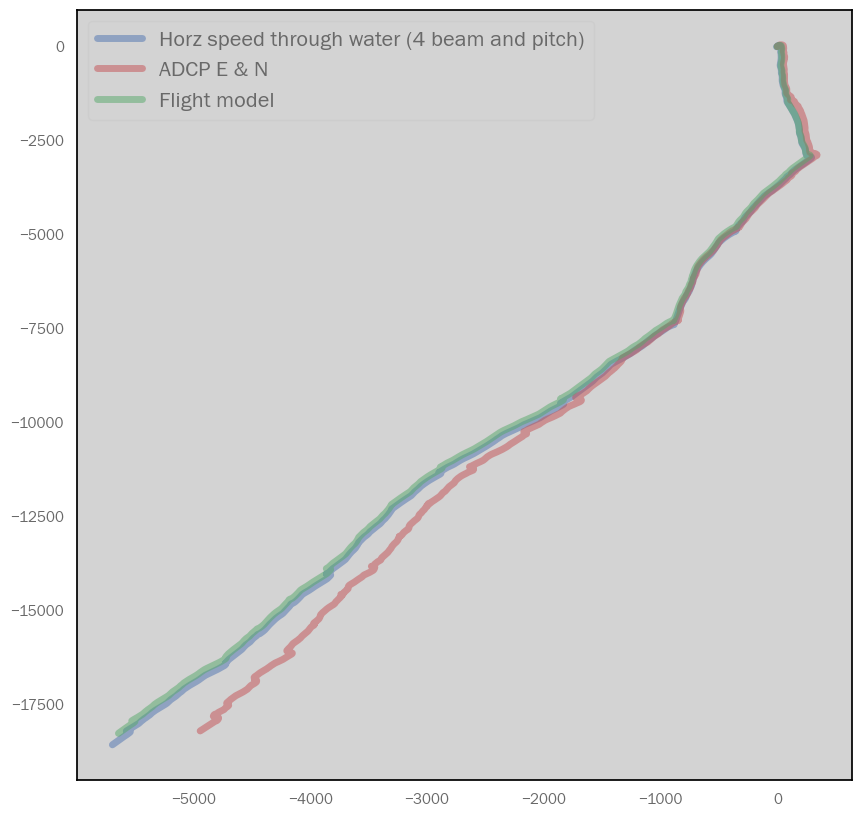

In [5]:
process_adcp.plot_subsurface_movement(ADCP, data, options)

/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:1336: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ffill = lambda arr: pd.DataFrame(arr).fillna(method='ffill').values.flatten()
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:1411: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider['DAC_E'] = glider['DAC_E'].fillna(method='bfill').fillna(method='ffill')
/home/callum/Documents/community/gliderad2cp/gliderad2cp/process_adcp.py:1412: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  glider['DAC_N'] = glider['DAC_N'].fillna(method='bfill').fillna(method='ffill')


No final GPS for dive 103.0


<Figure size 1500x700 with 0 Axes>

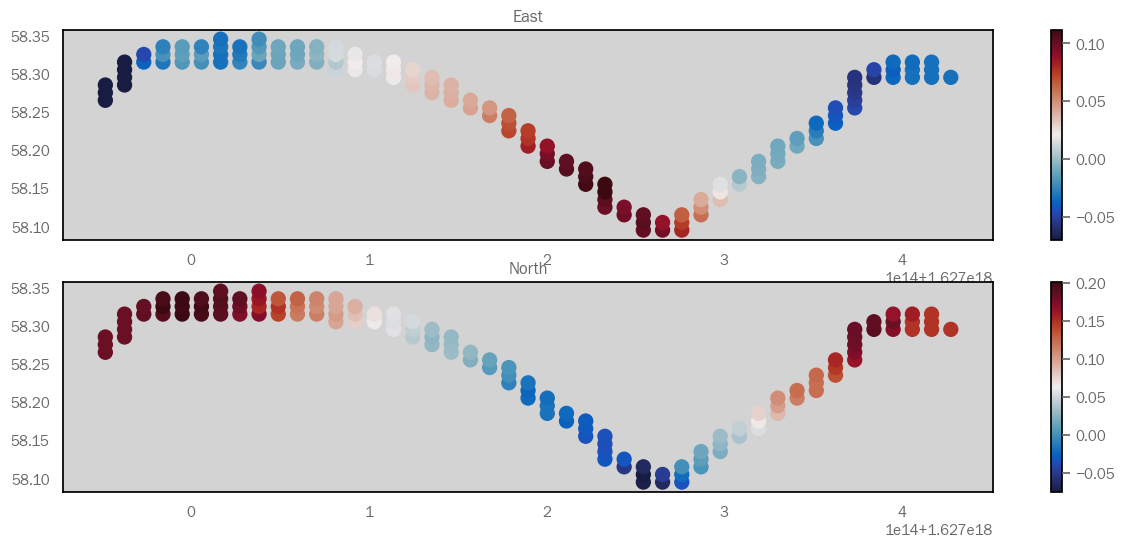

In [6]:
data = process_adcp.get_DAC(ADCP, data, options)

## 2.3. Get surface drift

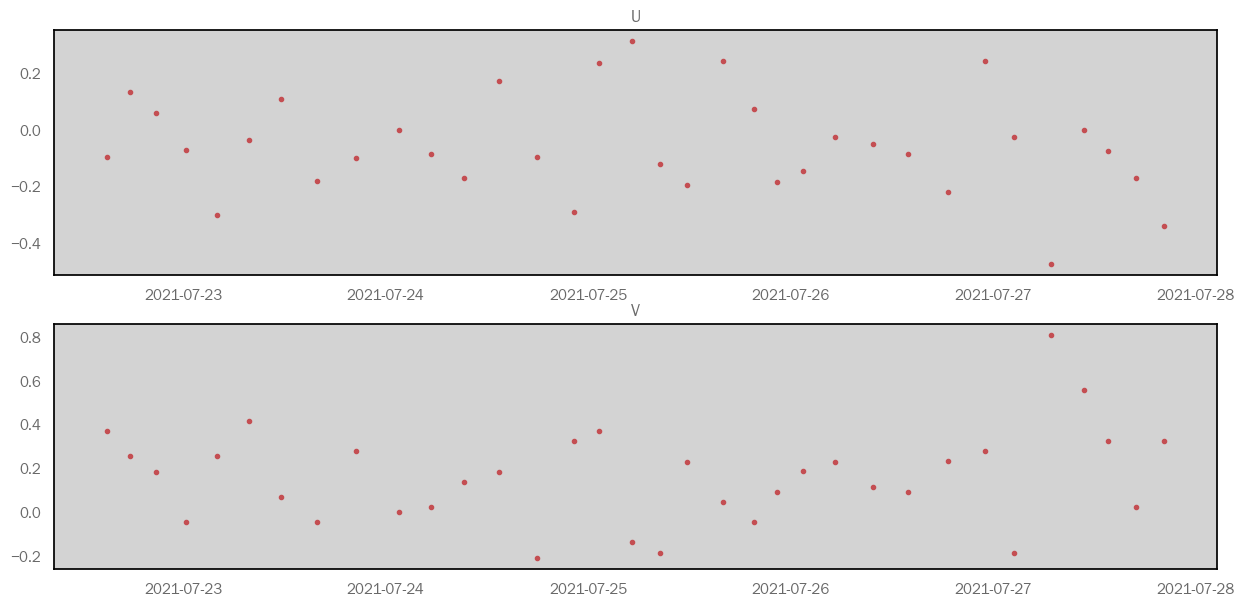

In [7]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 2.4. Get bottom track data 
Bottom track data only calculated if the ADCP is bottom mounted

In [8]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

2023-10-11 09:17:22 : ERROR: ADCP is top mounted. Not processing bottom track data


## 2.5. Reference ADCP data

Here we reference data to dive average current (DAC).

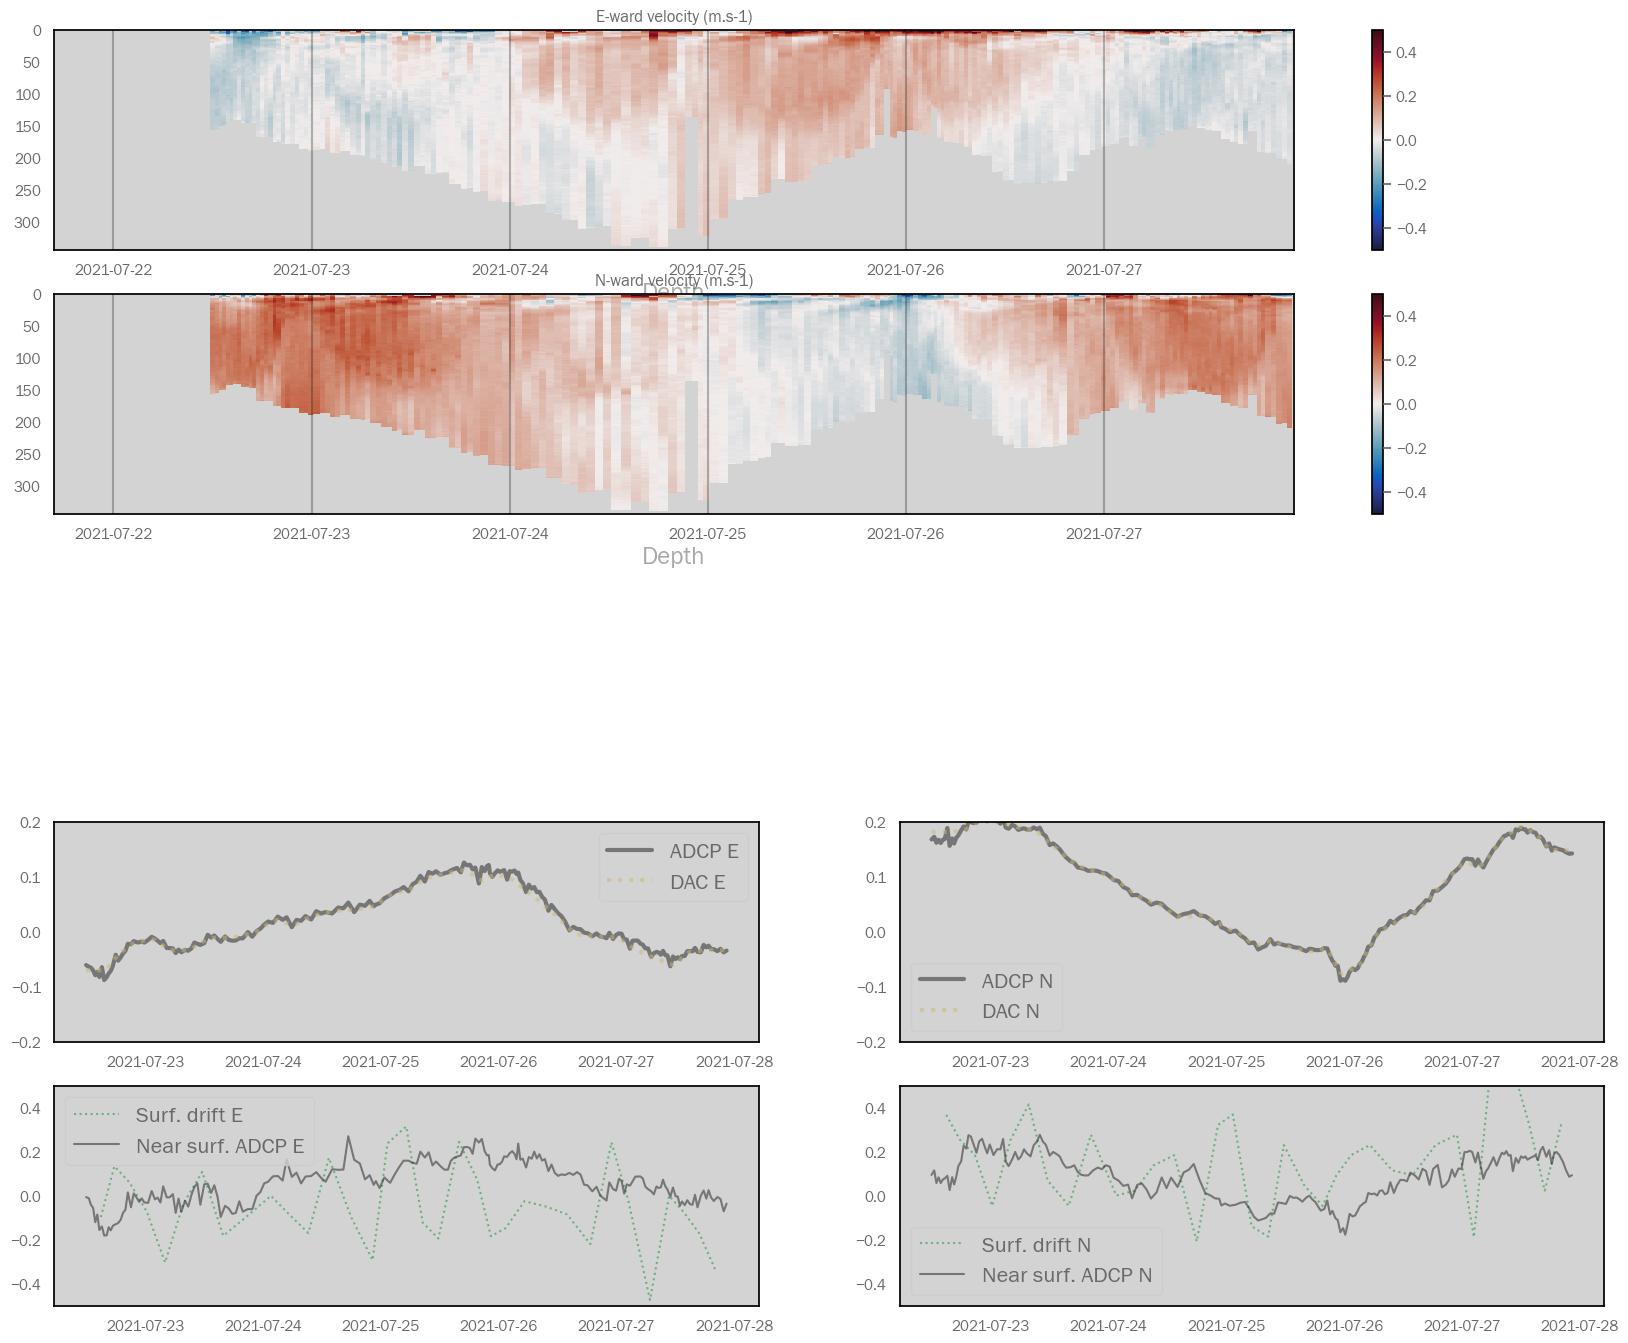

In [9]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

# VI. Grid and plot data

In [10]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.09it/s]


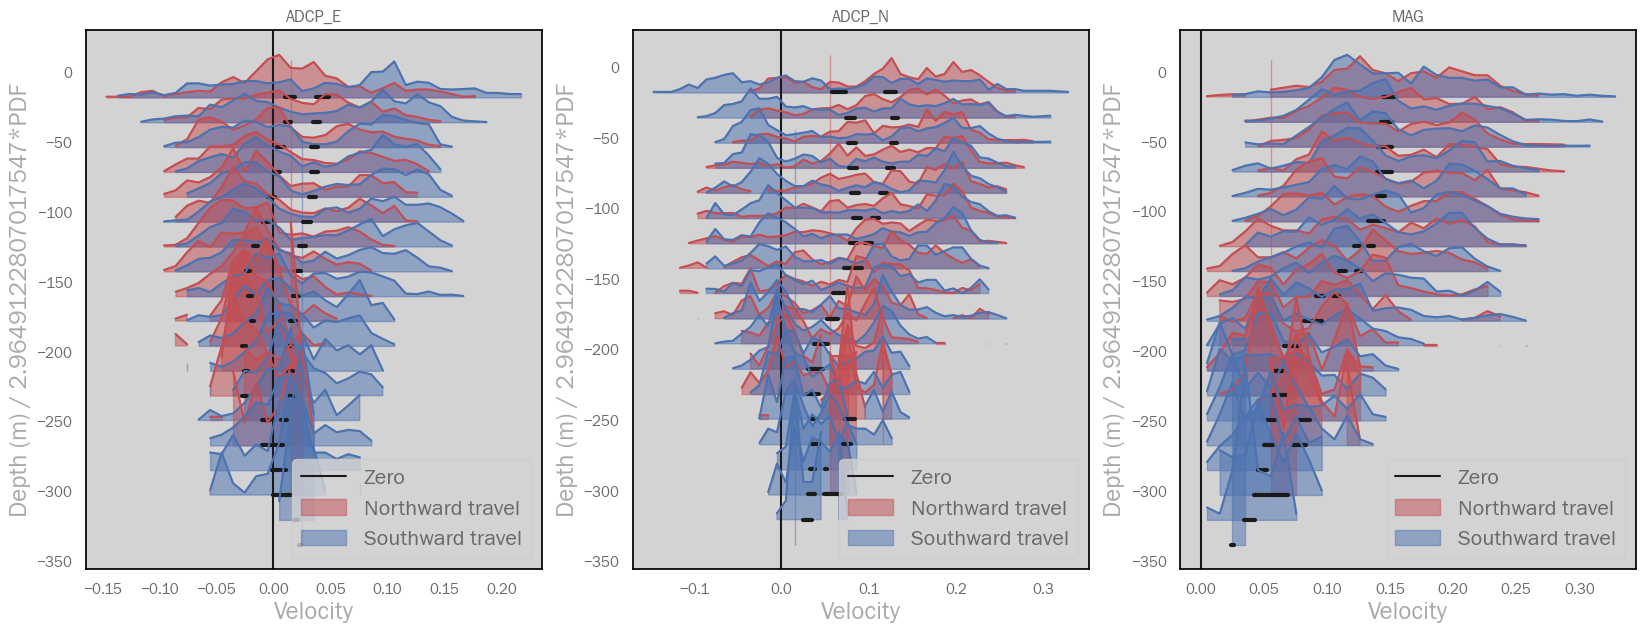

In [11]:
process_adcp.verify_depth_bias(out, yaxis, options)

 27%|███████████████████████████▊                                                                           | 27/100 [00:00<00:00, 314.47it/s]


Optimization terminated successfully.
         Current function value: 160946.605682
         Iterations: 27
         Function evaluations: 54
(array([0.00080442]), 160946.60568200704, 27, 54, 0)


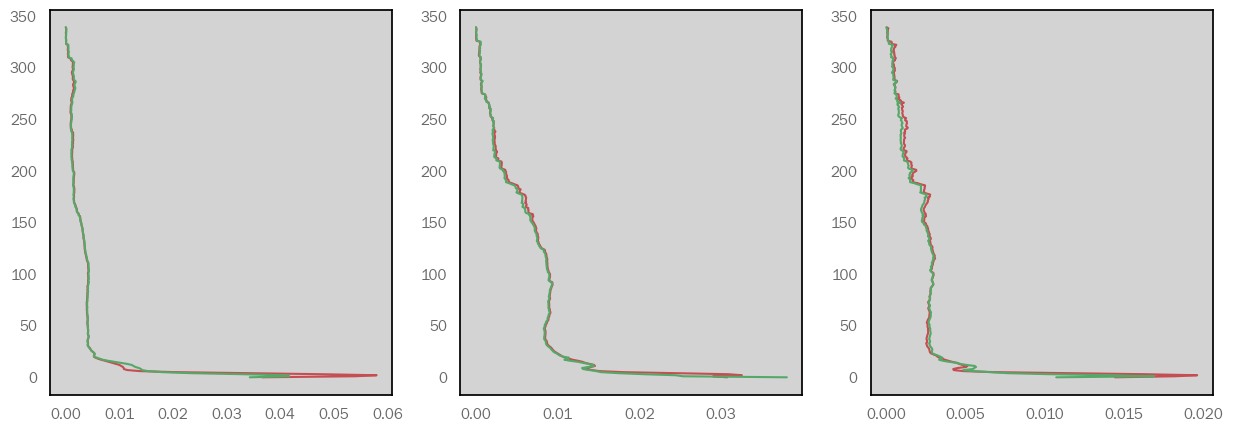

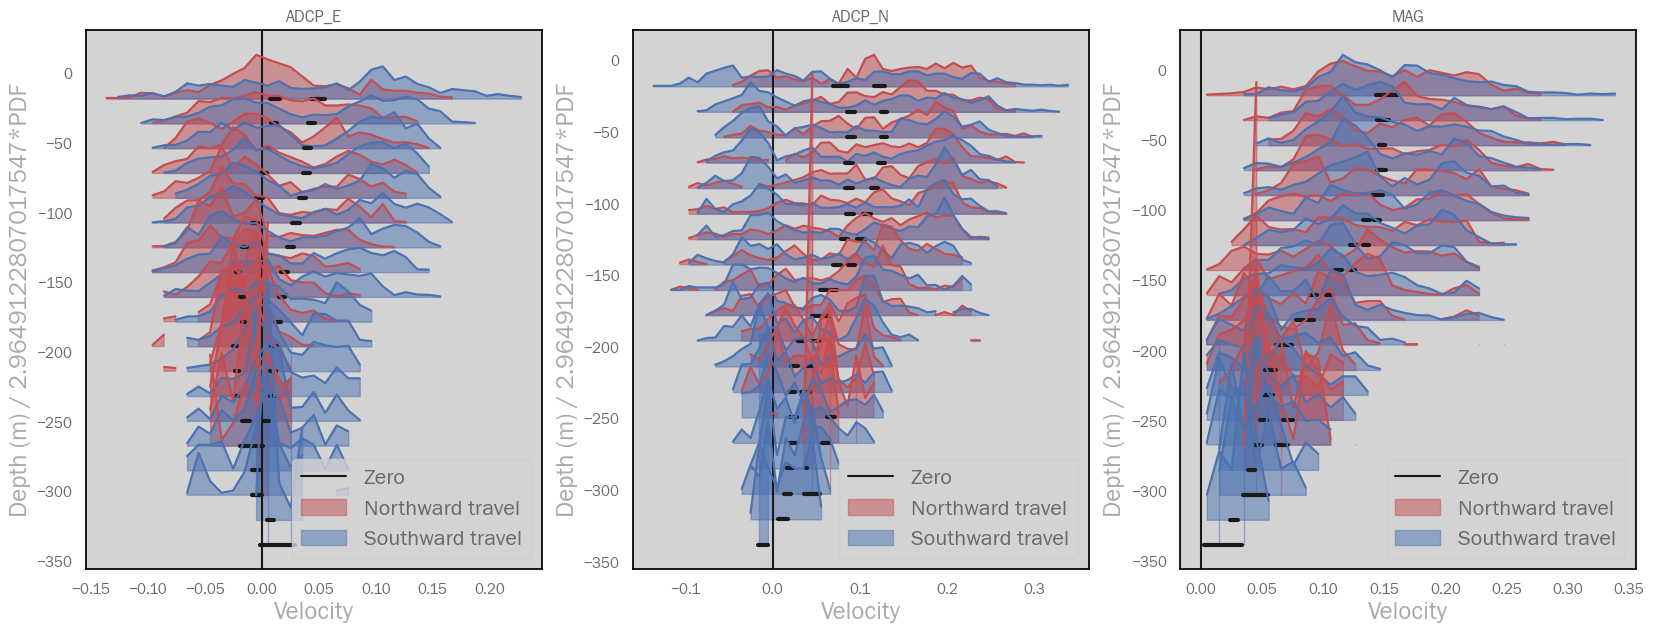

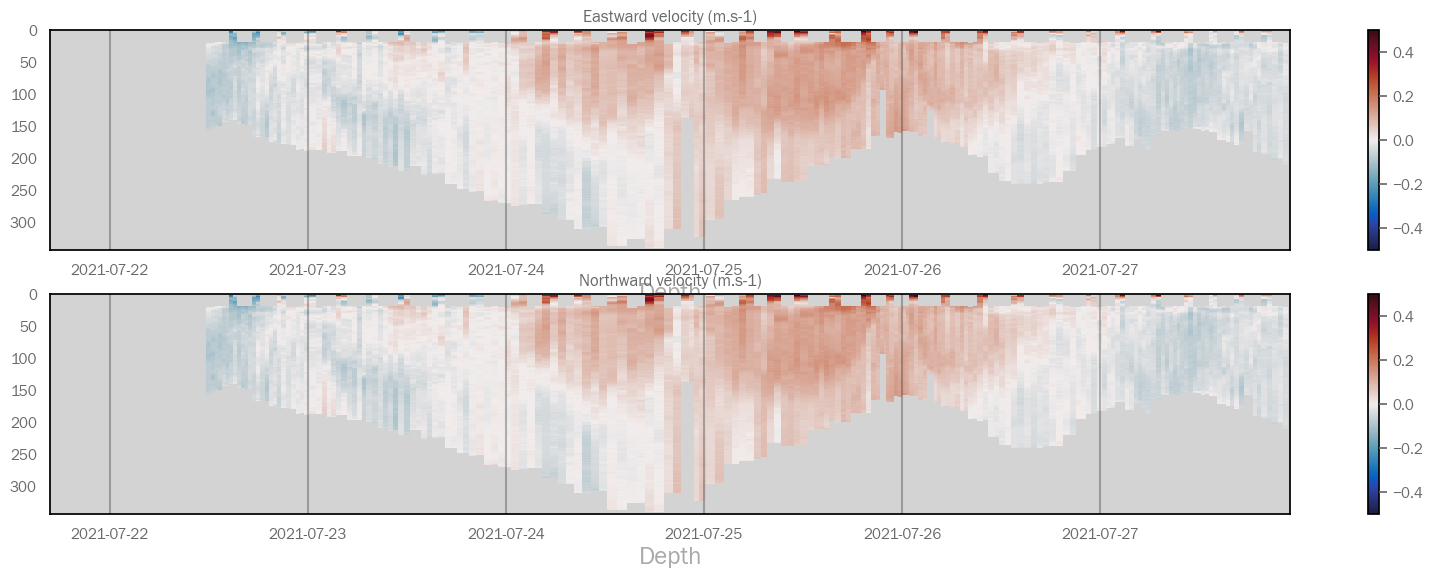

In [12]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

# Create xarray DataSet from `out` and compare results

In [13]:
ds = process_adcp.make_dataset(out)
ds_min = ds[['Sh_E', 'Sh_N','Sh_U', 'ADCP_E', 'ADCP_N']]

In [14]:
data_source.fetch(f"processed_velocity_{profile_range}.nc")
test_data_path = str(data_source.path / f"processed_velocity_{profile_range}.nc")
ds_min_test = xr.open_dataset(test_data_path)

The processing chain uses some non-determinate functions that can produce small numerical differences in results, so we test with `numpy.allclose` rather than `equals`

In [15]:
for var in list(ds_min):
    assert np.allclose(ds_min[var], ds_min_test[var], equal_nan=True, atol=1e-7, rtol=1e-3)